In [1]:
import sys
sys.path.insert(1, "../")
import numpy as np
import matplotlib.pyplot as plt
import scipy
from utils import topoPlotIndie

from scipy.special import legendre
from scipy.spatial.distance import pdist, squareform
from numpy.linalg import inv
from numpy import pi
from scipy.stats import zscore

In [2]:
## ????????????????????????????????????????????????????????????????????????
def laplacian_perrinX(data, x, y, z, leg_order=None, smoothing=1e-5):
    x, y, z = np.array(x), np.array(y), np.array(z)
    numelectrodes = len(x)

    if numelectrodes > 100:
        m = 3
        leg_order = 40 if leg_order is None else leg_order
    else:
        m = 4
        leg_order = 20 if leg_order is None else leg_order

    r = np.sqrt(x**2 + y**2 + z**2)
    x, y, z = x/r, y/r, z/r

    coords = np.vstack((x, y, z)).T
    sq_dist = squareform(pdist(coords, 'sqeuclidean'))
    cosdist = 1 - (sq_dist / 2)
    np.fill_diagonal(cosdist, 1)

    legpoly = np.zeros((leg_order, numelectrodes, numelectrodes))
    for ni in range(1, leg_order+1):
        P = legendre(ni)(cosdist)
        legpoly[ni-1, :, :] = P

    G = np.zeros((numelectrodes, numelectrodes))
    H = np.zeros((numelectrodes, numelectrodes))
    twoN1 = 2 * np.arange(1, leg_order+1) + 1
    gdenom = (np.arange(1, leg_order+1) * (np.arange(1, leg_order+1) + 1))**m
    hdenom = (np.arange(1, leg_order+1) * (np.arange(1, leg_order+1) + 1))**(m - 1)

    for i in range(numelectrodes):
        for j in range(i, numelectrodes):
            g = np.sum((twoN1 * legpoly[:, i, j]) / gdenom)
            h = -np.sum((twoN1 * legpoly[:, i, j]) / hdenom)
            G[i, j] = g / (4 * pi)
            H[i, j] = h / (4 * pi)

    G = G + G.T - np.diag(np.diag(G))
    H = H + H.T - np.diag(np.diag(H))

    G -= np.eye(numelectrodes) * G[0, 0] / 2
    H -= np.eye(numelectrodes) * H[0, 0] / 2

    orig_shape = data.shape
    data = data.reshape(numelectrodes, -1)

    Gs = G + np.eye(numelectrodes) * smoothing
    Gs_inv = inv(Gs)
    dataGs = data.T @ Gs_inv
    GsinvS = np.sum(Gs_inv, axis=0)
    correction = (np.sum(dataGs, axis=1) / np.sum(GsinvS))[:, np.newaxis] * GsinvS
    C = dataGs - correction

    surf_lap = (C @ H.T).T.reshape(orig_shape)

    return surf_lap, G, H

In [3]:
data = scipy.io.loadmat("../data/sampleEEGdata.mat")

dataA = data["EEG"]["data"][0][0]
times = data["EEG"]['times'][0][0][0].reshape(-1,1)

xloc =  []
yloc = []
zloc = []
for i in range(64):
    xloc.append(data["EEG"]["chanlocs"][0][0][0][i]["X"].item())
    yloc.append(data["EEG"]["chanlocs"][0][0][0][i]["Y"].item())
    zloc.append(data["EEG"]["chanlocs"][0][0][0][i]["Z"].item())

chan2plot = "P8"
chanidx = np.where(data["EEG"]['chanlocs'][0][0]['labels'][0] == chan2plot)[0]

time2plot = 250
tidx = np.argmin(abs(times - time2plot))

In [4]:
lap, _, _ = laplacian_perrinX(dataA, xloc, yloc, zloc)

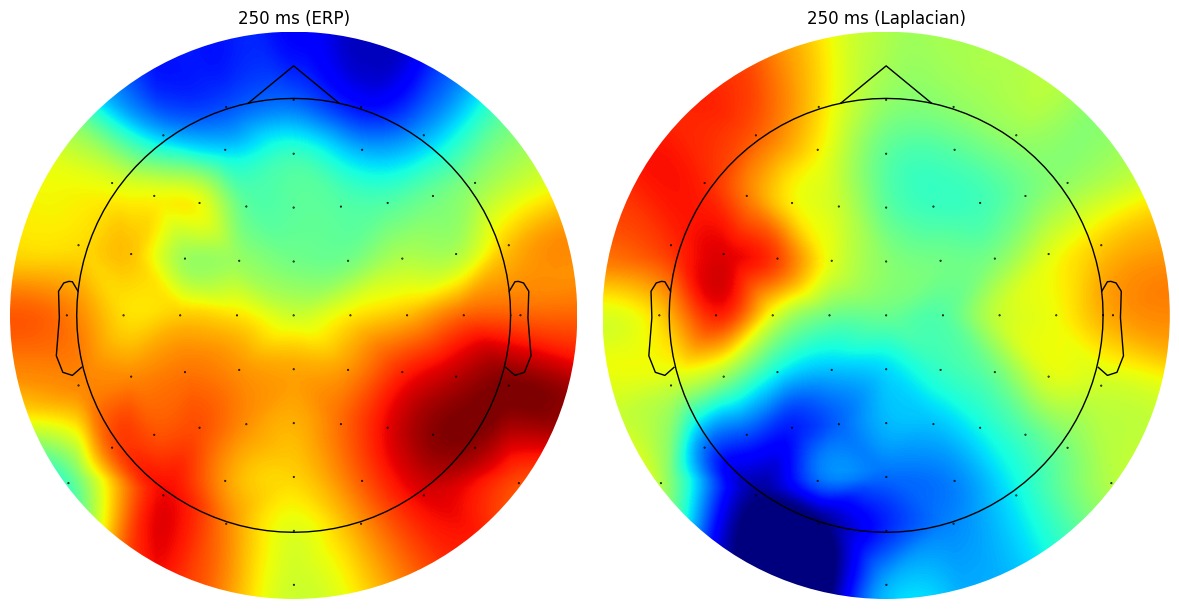

In [5]:
voltERP = np.mean(dataA, axis=2)
voltERP = zscore(voltERP, axis=1)

lapERP = np.mean(lap, axis=2)
lapERP = zscore(lapERP, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0] = topoPlotIndie(data["EEG"], voltERP[:, tidx], axes[0], f"{int(time2plot)} ms (ERP)", cmap="jet", contours=0)
axes[1] = topoPlotIndie(data["EEG"], lapERP[:, tidx], axes[1], f"{int(time2plot)} ms (Laplacian)", cmap="jet", contours=0)

plt.tight_layout()
plt.show()

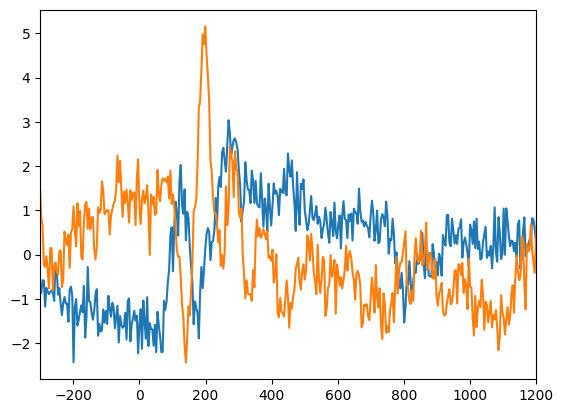

In [6]:
plt.plot(times, voltERP[chanidx].T)
plt.plot(times, lapERP[chanidx].T)
plt.xlim([-300,1200])
plt.show()